# Reproduce tractable models

In [1]:
import hypothesis
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal

## Forward model

In [2]:
from hypothesis.benchmark.tractable import Simulator

simulator = Simulator()

## Prior

In [3]:


class Uniform(torch.distributions.uniform.Uniform):

    def __init__(self, lower, upper):
        super(Uniform, self).__init__(lower, upper)

    def log_prob(self, sample):
        return super(Uniform, self).log_prob(sample).mean()


def Prior():
    lower = -3 * torch.ones(5).float()
    upper = 3 * torch.ones(5).float()

    return Uniform(lower, upper)

prior = Prior()

In [4]:
prior.sample(torch.Size([8])).shape

torch.Size([8, 5])

## Test GT posterior

In [5]:
from hypothesis.benchmark.tractable import log_likelihood

In [6]:
theta_star = torch.Tensor([0.7, -2.9, -1.0, -0.9, 0.6]).view(1, -1)
observation = torch.Tensor(np.load('observations.npy'))

In [7]:
prior.log_prob(theta_star)

tensor(-1.7918)

In [8]:
observation.shape

torch.Size([1, 8])

In [9]:
mcmc_samples_gt = np.load('mcmc_samples_gt.npy')

In [10]:
mcmc_samples_gt

array([[-2.8107648 , -2.7581644 , -2.3071456 ,  1.0062616 , -1.0369437 ],
       [-2.8107648 , -2.7581644 , -2.3071456 ,  1.0062616 , -1.0369437 ],
       [-2.8107648 , -2.7581644 , -2.3071456 ,  1.0062616 , -1.0369437 ],
       ...,
       [ 0.24206412, -2.189775  ,  1.1541371 , -0.7970873 , -0.3694483 ],
       [ 0.24206412, -2.189775  ,  1.1541371 , -0.7970873 , -0.3694483 ],
       [ 0.24206412, -2.189775  ,  1.1541371 , -0.7970873 , -0.3694483 ]],
      dtype=float32)

In [11]:
mcmc_samples_gt_tensor = torch.Tensor(mcmc_samples_gt)

In [12]:
mcmc_samples_gt_tensor

tensor([[-2.8108, -2.7582, -2.3071,  1.0063, -1.0369],
        [-2.8108, -2.7582, -2.3071,  1.0063, -1.0369],
        [-2.8108, -2.7582, -2.3071,  1.0063, -1.0369],
        ...,
        [ 0.2421, -2.1898,  1.1541, -0.7971, -0.3694],
        [ 0.2421, -2.1898,  1.1541, -0.7971, -0.3694],
        [ 0.2421, -2.1898,  1.1541, -0.7971, -0.3694]])

(array([7.5100e+02, 6.4100e+02, 6.5100e+02, 9.5400e+02, 1.3710e+03,
        1.1820e+03, 1.2620e+03, 1.8260e+03, 1.8020e+03, 2.0600e+03,
        2.3450e+03, 3.6930e+03, 3.4870e+03, 4.5980e+03, 4.5830e+03,
        5.3970e+03, 7.0660e+03, 8.7170e+03, 7.4730e+03, 1.0510e+04,
        1.2803e+04, 1.3959e+04, 1.4177e+04, 1.6237e+04, 2.1503e+04,
        2.1587e+04, 2.5143e+04, 2.8367e+04, 2.9449e+04, 3.2186e+04,
        3.4539e+04, 3.3884e+04, 3.2865e+04, 3.5596e+04, 3.6626e+04,
        2.0757e+04, 1.4884e+04, 7.2860e+03, 2.5000e+03, 1.8400e+02,
        1.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e+01,
        2.0200e+02, 1.7940e+03, 5.3450e+03, 1.5340e+04, 2.0422e+04,
        3.3141e+04, 3.7627e+04, 3.8006e+04, 3.0219e+04, 3.6636e+04,
        3.0012e+04, 2.8663e+04, 2.8874e+04, 2.86

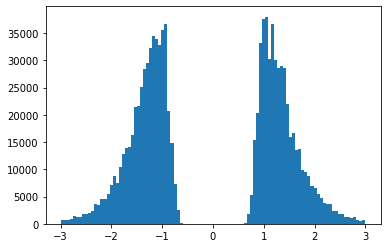

In [13]:
plt.hist(mcmc_samples_gt[:,2], bins=100)

## Likelihood-to-evidence ratio estimator

### Ratio estimator architecture

In [14]:
from hypothesis.nn.amortized_ratio_estimation import LikelihoodToEvidenceRatioEstimatorMLP as RatioEstimator

# Architecture definitions
activation = torch.nn.SELU
layers = [64, 64, 64]
inputs_shape = (5,)
outputs_shape = (8,)
dropout=False

# Allocation
ratio_estimator = RatioEstimator(
    activation=activation,
    shape_inputs=inputs_shape,
    shape_outputs=outputs_shape,
    dropout=dropout,
    layers=layers)
ratio_estimator = ratio_estimator.to(hypothesis.accelerator)
ratio_estimator = ratio_estimator.train()

### Training

In [15]:
import torch

from hypothesis.simulation import Simulator
from torch.utils.data import Dataset



class SimulatorDataset(Dataset):
    r"""

    Todo:
        Write docs.
    """

    def __init__(self, simulator, prior, size=1000000):
        super(SimulatorDataset, self).__init__()
        self.prior = prior
        self.simulator = simulator
        self.size = int(size)

    def __getitem__(self, index):
        r"""
        Todo:
            Write docs.
        """
        passed = False
        while not passed:
            try:
                inputs = self.prior.sample(torch.Size([1]))
                outputs = self.simulator(inputs)
                inputs = inputs.squeeze()
                outputs = outputs.squeeze()
                passed = True
            except Exception as e:
                print(e)

        return inputs, outputs

    def __len__(self):
        r"""
        Todo:
            Write docs.
        """
        return self.size


In [16]:
from hypothesis.nn.amortized_ratio_estimation import LikelihoodToEvidenceCriterion as Criterion
from hypothesis.visualization.util import make_square

batch_size = 256
epochs = 250

dataset = SimulatorDataset(simulator, prior)
criterion = Criterion(estimator=ratio_estimator, batch_size=batch_size).to(hypothesis.accelerator)

  0%|          | 1/250 [02:05<8:41:55, 125.77s/it]

Epoch done : 1 / 250


  1%|          | 2/250 [04:14<8:43:41, 126.70s/it]

Epoch done : 2 / 250
cholesky_cpu: U(2,2) is zero, singular U.


  1%|          | 3/250 [06:22<8:42:59, 127.04s/it]

Epoch done : 3 / 250


  2%|▏         | 4/250 [08:31<8:43:24, 127.66s/it]

Epoch done : 4 / 250


  2%|▏         | 5/250 [10:40<8:42:29, 127.96s/it]

Epoch done : 5 / 250


  2%|▏         | 6/250 [12:48<8:41:09, 128.16s/it]

Epoch done : 6 / 250


  3%|▎         | 7/250 [14:58<8:41:00, 128.64s/it]

Epoch done : 7 / 250
cholesky_cpu: U(1,1) is zero, singular U.


  3%|▎         | 8/250 [17:07<8:38:51, 128.64s/it]

Epoch done : 8 / 250


  4%|▎         | 9/250 [19:12<8:32:52, 127.69s/it]

Epoch done : 9 / 250
cholesky_cpu: U(2,2) is zero, singular U.


  4%|▍         | 10/250 [21:25<8:36:17, 129.07s/it]

Epoch done : 10 / 250


  4%|▍         | 11/250 [23:33<8:33:51, 129.00s/it]

Epoch done : 11 / 250


  5%|▍         | 12/250 [25:39<8:27:16, 127.88s/it]

Epoch done : 12 / 250


  5%|▌         | 13/250 [27:44<8:22:19, 127.17s/it]

Epoch done : 13 / 250


  6%|▌         | 14/250 [29:49<8:16:58, 126.35s/it]

Epoch done : 14 / 250


  6%|▌         | 15/250 [32:01<8:22:27, 128.29s/it]

Epoch done : 15 / 250


  6%|▋         | 16/250 [34:16<8:28:14, 130.32s/it]

Epoch done : 16 / 250


  7%|▋         | 17/250 [36:28<8:27:52, 130.78s/it]

Epoch done : 17 / 250


  7%|▋         | 18/250 [38:35<8:21:21, 129.66s/it]

Epoch done : 18 / 250


  8%|▊         | 19/250 [40:42<8:15:11, 128.62s/it]

Epoch done : 19 / 250


  8%|▊         | 20/250 [42:51<8:14:24, 128.97s/it]

Epoch done : 20 / 250
cholesky_cpu: U(1,1) is zero, singular U.


  8%|▊         | 21/250 [44:54<8:05:24, 127.18s/it]

Epoch done : 21 / 250


  9%|▉         | 22/250 [46:59<8:00:21, 126.41s/it]

Epoch done : 22 / 250


  9%|▉         | 23/250 [49:00<7:52:21, 124.85s/it]

Epoch done : 23 / 250


 10%|▉         | 24/250 [51:06<7:51:22, 125.14s/it]

Epoch done : 24 / 250


 10%|█         | 25/250 [53:11<7:49:21, 125.16s/it]

Epoch done : 25 / 250


 10%|█         | 26/250 [55:14<7:44:59, 124.55s/it]

Epoch done : 26 / 250


 11%|█         | 27/250 [57:23<7:47:40, 125.83s/it]

Epoch done : 27 / 250


 11%|█         | 28/250 [59:32<7:49:14, 126.82s/it]

Epoch done : 28 / 250


 12%|█▏        | 29/250 [1:01:42<7:50:44, 127.81s/it]

Epoch done : 29 / 250


 12%|█▏        | 30/250 [1:03:48<7:45:43, 127.01s/it]

Epoch done : 30 / 250


 12%|█▏        | 31/250 [1:05:59<7:48:00, 128.22s/it]

Epoch done : 31 / 250


 13%|█▎        | 32/250 [1:08:05<7:44:06, 127.74s/it]

Epoch done : 32 / 250


 13%|█▎        | 33/250 [1:10:10<7:38:52, 126.88s/it]

Epoch done : 33 / 250


 14%|█▎        | 34/250 [1:12:20<7:40:03, 127.80s/it]

Epoch done : 34 / 250


 14%|█▍        | 35/250 [1:14:26<7:35:58, 127.25s/it]

Epoch done : 35 / 250


 14%|█▍        | 36/250 [1:16:35<7:35:28, 127.70s/it]

Epoch done : 36 / 250


 15%|█▍        | 37/250 [1:18:40<7:30:53, 127.01s/it]

Epoch done : 37 / 250


 15%|█▌        | 38/250 [1:20:42<7:23:47, 125.60s/it]

Epoch done : 38 / 250


 16%|█▌        | 39/250 [1:22:44<7:17:07, 124.30s/it]

Epoch done : 39 / 250


 16%|█▌        | 40/250 [1:24:50<7:17:28, 124.99s/it]

Epoch done : 40 / 250


 16%|█▋        | 41/250 [1:26:56<7:15:57, 125.15s/it]

Epoch done : 41 / 250


 17%|█▋        | 42/250 [1:28:58<7:11:12, 124.39s/it]

Epoch done : 42 / 250


 17%|█▋        | 43/250 [1:31:04<7:10:08, 124.68s/it]

Epoch done : 43 / 250


 18%|█▊        | 44/250 [1:33:10<7:09:33, 125.11s/it]

Epoch done : 44 / 250


 18%|█▊        | 45/250 [1:35:12<7:03:59, 124.09s/it]

Epoch done : 45 / 250


 18%|█▊        | 46/250 [1:37:15<7:01:08, 123.87s/it]

Epoch done : 46 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 19%|█▉        | 47/250 [1:39:17<6:57:26, 123.38s/it]

Epoch done : 47 / 250


 19%|█▉        | 48/250 [1:41:22<6:56:19, 123.66s/it]

Epoch done : 48 / 250


 20%|█▉        | 49/250 [1:43:27<6:56:09, 124.22s/it]

Epoch done : 49 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 20%|██        | 50/250 [1:45:30<6:53:08, 123.94s/it]

Epoch done : 50 / 250


 20%|██        | 51/250 [1:47:32<6:48:18, 123.11s/it]

Epoch done : 51 / 250


 21%|██        | 52/250 [1:49:35<6:46:59, 123.33s/it]

Epoch done : 52 / 250


 21%|██        | 53/250 [1:51:40<6:46:02, 123.67s/it]

Epoch done : 53 / 250


 22%|██▏       | 54/250 [1:53:44<6:44:24, 123.80s/it]

Epoch done : 54 / 250


 22%|██▏       | 55/250 [1:55:48<6:42:25, 123.82s/it]

Epoch done : 55 / 250


 22%|██▏       | 56/250 [1:57:50<6:38:22, 123.21s/it]

Epoch done : 56 / 250


 23%|██▎       | 57/250 [1:59:52<6:35:53, 123.07s/it]

Epoch done : 57 / 250


 23%|██▎       | 58/250 [2:01:55<6:33:48, 123.06s/it]

Epoch done : 58 / 250


 24%|██▎       | 59/250 [2:03:56<6:29:39, 122.40s/it]

Epoch done : 59 / 250


 24%|██▍       | 60/250 [2:05:56<6:25:22, 121.70s/it]

Epoch done : 60 / 250


 24%|██▍       | 61/250 [2:07:59<6:24:37, 122.10s/it]

Epoch done : 61 / 250


 25%|██▍       | 62/250 [2:10:02<6:23:30, 122.40s/it]

Epoch done : 62 / 250


 25%|██▌       | 63/250 [2:12:07<6:23:22, 123.01s/it]

Epoch done : 63 / 250


 26%|██▌       | 64/250 [2:14:10<6:21:29, 123.06s/it]

Epoch done : 64 / 250


 26%|██▌       | 65/250 [2:16:14<6:20:20, 123.36s/it]

Epoch done : 65 / 250


 26%|██▋       | 66/250 [2:18:16<6:16:34, 122.80s/it]

Epoch done : 66 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 27%|██▋       | 67/250 [2:20:18<6:13:54, 122.59s/it]

Epoch done : 67 / 250


 27%|██▋       | 68/250 [2:22:20<6:11:30, 122.48s/it]

Epoch done : 68 / 250


 28%|██▊       | 69/250 [2:24:22<6:08:50, 122.27s/it]

Epoch done : 69 / 250


 28%|██▊       | 70/250 [2:26:25<6:07:22, 122.46s/it]

Epoch done : 70 / 250


 28%|██▊       | 71/250 [2:28:26<6:04:10, 122.07s/it]

Epoch done : 71 / 250


 29%|██▉       | 72/250 [2:30:28<6:01:54, 121.99s/it]

Epoch done : 72 / 250


 29%|██▉       | 73/250 [2:32:33<6:02:57, 123.04s/it]

Epoch done : 73 / 250


 30%|██▉       | 74/250 [2:34:35<5:59:33, 122.58s/it]

Epoch done : 74 / 250


 30%|███       | 75/250 [2:36:38<5:57:50, 122.69s/it]

Epoch done : 75 / 250


 30%|███       | 76/250 [2:38:40<5:55:57, 122.75s/it]

Epoch done : 76 / 250


 31%|███       | 77/250 [2:40:41<5:52:01, 122.09s/it]

Epoch done : 77 / 250


 31%|███       | 78/250 [2:42:42<5:49:05, 121.77s/it]

Epoch done : 78 / 250


 32%|███▏      | 79/250 [2:44:43<5:46:45, 121.67s/it]

Epoch done : 79 / 250


 32%|███▏      | 80/250 [2:46:47<5:46:31, 122.30s/it]

Epoch done : 80 / 250


 32%|███▏      | 81/250 [2:48:45<5:40:52, 121.02s/it]

Epoch done : 81 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 33%|███▎      | 82/250 [2:50:50<5:42:21, 122.27s/it]

Epoch done : 82 / 250


 33%|███▎      | 83/250 [2:52:54<5:41:13, 122.60s/it]

Epoch done : 83 / 250


 34%|███▎      | 84/250 [2:54:56<5:38:45, 122.44s/it]

Epoch done : 84 / 250


 34%|███▍      | 85/250 [2:56:56<5:34:25, 121.61s/it]

Epoch done : 85 / 250


 34%|███▍      | 86/250 [2:58:58<5:32:53, 121.79s/it]

Epoch done : 86 / 250


 35%|███▍      | 87/250 [3:01:02<5:32:54, 122.55s/it]

Epoch done : 87 / 250


 35%|███▌      | 88/250 [3:03:02<5:29:03, 121.87s/it]

Epoch done : 88 / 250


 36%|███▌      | 89/250 [3:05:04<5:26:59, 121.86s/it]

Epoch done : 89 / 250


 36%|███▌      | 90/250 [3:07:06<5:24:40, 121.75s/it]

Epoch done : 90 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 36%|███▋      | 91/250 [3:09:10<5:24:39, 122.51s/it]

Epoch done : 91 / 250


 37%|███▋      | 92/250 [3:11:14<5:23:53, 123.00s/it]

Epoch done : 92 / 250


 37%|███▋      | 93/250 [3:13:17<5:22:04, 123.08s/it]

Epoch done : 93 / 250


 38%|███▊      | 94/250 [3:15:20<5:19:21, 122.83s/it]

Epoch done : 94 / 250


 38%|███▊      | 95/250 [3:17:22<5:16:46, 122.62s/it]

Epoch done : 95 / 250


 38%|███▊      | 96/250 [3:19:25<5:15:34, 122.95s/it]

Epoch done : 96 / 250


 39%|███▉      | 97/250 [3:21:29<5:13:56, 123.12s/it]

Epoch done : 97 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 39%|███▉      | 98/250 [3:23:30<5:10:10, 122.44s/it]

Epoch done : 98 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 40%|███▉      | 99/250 [3:25:28<5:05:06, 121.23s/it]

Epoch done : 99 / 250


 40%|████      | 100/250 [3:27:31<5:04:20, 121.73s/it]

Epoch done : 100 / 250


 40%|████      | 101/250 [3:29:36<5:04:19, 122.55s/it]

Epoch done : 101 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 41%|████      | 102/250 [3:31:40<5:03:21, 122.99s/it]

Epoch done : 102 / 250


 41%|████      | 103/250 [3:33:41<4:59:59, 122.44s/it]

Epoch done : 103 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 42%|████▏     | 104/250 [3:35:43<4:57:26, 122.24s/it]

Epoch done : 104 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 42%|████▏     | 105/250 [3:37:45<4:55:51, 122.43s/it]

Epoch done : 105 / 250


 42%|████▏     | 106/250 [3:39:48<4:53:49, 122.43s/it]

Epoch done : 106 / 250


 43%|████▎     | 107/250 [3:41:50<4:51:37, 122.36s/it]

Epoch done : 107 / 250


 43%|████▎     | 108/250 [3:43:54<4:50:43, 122.84s/it]

Epoch done : 108 / 250


 44%|████▎     | 109/250 [3:45:57<4:48:29, 122.76s/it]

Epoch done : 109 / 250


 44%|████▍     | 110/250 [3:47:59<4:46:02, 122.59s/it]

Epoch done : 110 / 250


 44%|████▍     | 111/250 [3:50:01<4:43:48, 122.51s/it]

Epoch done : 111 / 250


 45%|████▍     | 112/250 [3:52:05<4:43:02, 123.06s/it]

Epoch done : 112 / 250


 45%|████▌     | 113/250 [3:54:09<4:41:17, 123.19s/it]

Epoch done : 113 / 250


 46%|████▌     | 114/250 [3:56:13<4:39:41, 123.40s/it]

Epoch done : 114 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 46%|████▌     | 115/250 [3:58:14<4:36:23, 122.84s/it]

Epoch done : 115 / 250


 46%|████▋     | 116/250 [4:00:18<4:34:47, 123.04s/it]

Epoch done : 116 / 250


 47%|████▋     | 117/250 [4:02:22<4:33:22, 123.32s/it]

Epoch done : 117 / 250


 47%|████▋     | 118/250 [4:04:23<4:29:36, 122.55s/it]

Epoch done : 118 / 250


 48%|████▊     | 119/250 [4:06:27<4:28:47, 123.11s/it]

Epoch done : 119 / 250


 48%|████▊     | 120/250 [4:08:28<4:25:27, 122.52s/it]

Epoch done : 120 / 250


 48%|████▊     | 121/250 [4:10:27<4:21:19, 121.55s/it]

Epoch done : 121 / 250


 49%|████▉     | 122/250 [4:12:31<4:20:21, 122.05s/it]

Epoch done : 122 / 250


 49%|████▉     | 123/250 [4:14:32<4:17:59, 121.88s/it]

Epoch done : 123 / 250


 50%|████▉     | 124/250 [4:16:34<4:16:04, 121.94s/it]

Epoch done : 124 / 250


 50%|█████     | 125/250 [4:18:36<4:13:56, 121.89s/it]

Epoch done : 125 / 250


 50%|█████     | 126/250 [4:20:38<4:11:47, 121.84s/it]

Epoch done : 126 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 51%|█████     | 127/250 [4:22:41<4:10:55, 122.40s/it]

Epoch done : 127 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 51%|█████     | 128/250 [4:24:45<4:09:24, 122.66s/it]

Epoch done : 128 / 250


 52%|█████▏    | 129/250 [4:26:46<4:06:50, 122.40s/it]

Epoch done : 129 / 250


 52%|█████▏    | 130/250 [4:28:52<4:06:29, 123.25s/it]

Epoch done : 130 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 52%|█████▏    | 131/250 [4:30:54<4:03:34, 122.81s/it]

Epoch done : 131 / 250
cholesky_cpu: U(2,2) is zero, singular U.
cholesky_cpu: U(2,2) is zero, singular U.


 53%|█████▎    | 132/250 [4:32:55<4:00:30, 122.29s/it]

Epoch done : 132 / 250


 53%|█████▎    | 133/250 [4:34:56<3:58:10, 122.14s/it]

Epoch done : 133 / 250


 54%|█████▎    | 134/250 [4:37:01<3:57:18, 122.75s/it]

Epoch done : 134 / 250


 54%|█████▍    | 135/250 [4:39:05<3:56:12, 123.24s/it]

Epoch done : 135 / 250


 54%|█████▍    | 136/250 [4:41:07<3:53:36, 122.95s/it]

Epoch done : 136 / 250


 55%|█████▍    | 137/250 [4:43:07<3:49:52, 122.06s/it]

Epoch done : 137 / 250


 55%|█████▌    | 138/250 [4:45:12<3:49:21, 122.87s/it]

Epoch done : 138 / 250


 56%|█████▌    | 139/250 [4:47:16<3:47:49, 123.15s/it]

Epoch done : 139 / 250


 56%|█████▌    | 140/250 [4:49:19<3:45:48, 123.16s/it]

Epoch done : 140 / 250


 56%|█████▋    | 141/250 [4:51:23<3:44:10, 123.40s/it]

Epoch done : 141 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 57%|█████▋    | 142/250 [4:53:27<3:42:28, 123.60s/it]

Epoch done : 142 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 57%|█████▋    | 143/250 [4:55:29<3:39:39, 123.18s/it]

Epoch done : 143 / 250


 58%|█████▊    | 144/250 [4:57:32<3:37:22, 123.05s/it]

Epoch done : 144 / 250


 58%|█████▊    | 145/250 [4:59:34<3:35:04, 122.90s/it]

Epoch done : 145 / 250


 58%|█████▊    | 146/250 [5:01:38<3:33:31, 123.19s/it]

Epoch done : 146 / 250


 59%|█████▉    | 147/250 [5:03:41<3:31:17, 123.09s/it]

Epoch done : 147 / 250


 59%|█████▉    | 148/250 [5:05:43<3:28:41, 122.76s/it]

Epoch done : 148 / 250


 60%|█████▉    | 149/250 [5:07:46<3:26:34, 122.72s/it]

Epoch done : 149 / 250


 60%|██████    | 150/250 [5:09:46<3:23:31, 122.11s/it]

Epoch done : 150 / 250


 60%|██████    | 151/250 [5:11:50<3:22:26, 122.69s/it]

Epoch done : 151 / 250


 61%|██████    | 152/250 [5:13:51<3:19:23, 122.08s/it]

Epoch done : 152 / 250


 61%|██████    | 153/250 [5:15:55<3:18:26, 122.75s/it]

Epoch done : 153 / 250


 62%|██████▏   | 154/250 [5:17:59<3:16:48, 123.01s/it]

Epoch done : 154 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 62%|██████▏   | 155/250 [5:20:00<3:13:42, 122.34s/it]

Epoch done : 155 / 250


 62%|██████▏   | 156/250 [5:21:59<3:10:19, 121.49s/it]

Epoch done : 156 / 250


 63%|██████▎   | 157/250 [5:24:01<3:08:31, 121.63s/it]

Epoch done : 157 / 250


 63%|██████▎   | 158/250 [5:26:03<3:06:28, 121.61s/it]

Epoch done : 158 / 250


 64%|██████▎   | 159/250 [5:28:14<3:08:38, 124.38s/it]

Epoch done : 159 / 250


 64%|██████▍   | 160/250 [5:30:25<3:09:52, 126.58s/it]

Epoch done : 160 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 64%|██████▍   | 161/250 [5:32:39<3:11:02, 128.80s/it]

Epoch done : 161 / 250


 65%|██████▍   | 162/250 [5:34:46<3:07:44, 128.01s/it]

Epoch done : 162 / 250


 65%|██████▌   | 163/250 [5:36:54<3:05:36, 128.01s/it]

Epoch done : 163 / 250


 66%|██████▌   | 164/250 [5:39:02<3:03:33, 128.06s/it]

Epoch done : 164 / 250


 66%|██████▌   | 165/250 [5:41:13<3:02:41, 128.96s/it]

Epoch done : 165 / 250


 66%|██████▋   | 166/250 [5:43:18<2:59:06, 127.93s/it]

Epoch done : 166 / 250


 67%|██████▋   | 167/250 [5:45:27<2:57:16, 128.15s/it]

Epoch done : 167 / 250


 67%|██████▋   | 168/250 [5:47:35<2:55:14, 128.23s/it]

Epoch done : 168 / 250


 68%|██████▊   | 169/250 [5:49:45<2:53:33, 128.56s/it]

Epoch done : 169 / 250


 68%|██████▊   | 170/250 [5:51:55<2:51:59, 128.99s/it]

Epoch done : 170 / 250


 68%|██████▊   | 171/250 [5:54:03<2:49:44, 128.92s/it]

Epoch done : 171 / 250


 69%|██████▉   | 172/250 [5:56:13<2:47:55, 129.17s/it]

Epoch done : 172 / 250


 69%|██████▉   | 173/250 [5:58:23<2:45:50, 129.22s/it]

Epoch done : 173 / 250


 70%|██████▉   | 174/250 [6:00:31<2:43:20, 128.95s/it]

Epoch done : 174 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 70%|███████   | 175/250 [6:02:39<2:40:50, 128.67s/it]

Epoch done : 175 / 250


 70%|███████   | 176/250 [6:04:47<2:38:36, 128.61s/it]

Epoch done : 176 / 250


 71%|███████   | 177/250 [6:06:56<2:36:24, 128.55s/it]

Epoch done : 177 / 250


 71%|███████   | 178/250 [6:09:04<2:34:14, 128.54s/it]

Epoch done : 178 / 250


 72%|███████▏  | 179/250 [6:11:15<2:32:55, 129.24s/it]

Epoch done : 179 / 250


 72%|███████▏  | 180/250 [6:13:26<2:31:22, 129.75s/it]

Epoch done : 180 / 250


 72%|███████▏  | 181/250 [6:15:36<2:29:06, 129.65s/it]

Epoch done : 181 / 250


 73%|███████▎  | 182/250 [6:17:46<2:27:10, 129.85s/it]

Epoch done : 182 / 250


 73%|███████▎  | 183/250 [6:19:55<2:24:39, 129.55s/it]

Epoch done : 183 / 250


 74%|███████▎  | 184/250 [6:21:59<2:20:40, 127.89s/it]

Epoch done : 184 / 250


 74%|███████▍  | 185/250 [6:24:11<2:19:59, 129.22s/it]

Epoch done : 185 / 250


 74%|███████▍  | 186/250 [6:26:24<2:18:52, 130.20s/it]

Epoch done : 186 / 250


 75%|███████▍  | 187/250 [6:28:30<2:15:29, 129.04s/it]

Epoch done : 187 / 250


 75%|███████▌  | 188/250 [6:30:32<2:11:03, 126.83s/it]

Epoch done : 188 / 250


 76%|███████▌  | 189/250 [6:32:36<2:08:18, 126.21s/it]

Epoch done : 189 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 76%|███████▌  | 190/250 [6:34:38<2:04:45, 124.75s/it]

Epoch done : 190 / 250


 76%|███████▋  | 191/250 [6:36:41<2:02:17, 124.37s/it]

Epoch done : 191 / 250


 77%|███████▋  | 192/250 [6:38:45<1:59:56, 124.08s/it]

Epoch done : 192 / 250


 77%|███████▋  | 193/250 [6:40:47<1:57:25, 123.61s/it]

Epoch done : 193 / 250


 78%|███████▊  | 194/250 [6:42:49<1:54:52, 123.08s/it]

Epoch done : 194 / 250


 78%|███████▊  | 195/250 [6:44:49<1:52:01, 122.21s/it]

Epoch done : 195 / 250


 78%|███████▊  | 196/250 [6:46:48<1:49:09, 121.28s/it]

Epoch done : 196 / 250


 79%|███████▉  | 197/250 [6:48:50<1:47:16, 121.44s/it]

Epoch done : 197 / 250


 79%|███████▉  | 198/250 [6:50:50<1:44:50, 120.98s/it]

Epoch done : 198 / 250


 80%|███████▉  | 199/250 [6:52:54<1:43:41, 121.98s/it]

Epoch done : 199 / 250


 80%|████████  | 200/250 [6:54:55<1:41:15, 121.51s/it]

Epoch done : 200 / 250


 80%|████████  | 201/250 [6:56:58<1:39:46, 122.17s/it]

Epoch done : 201 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 81%|████████  | 202/250 [6:58:58<1:37:12, 121.51s/it]

Epoch done : 202 / 250


 81%|████████  | 203/250 [7:00:58<1:34:49, 121.06s/it]

Epoch done : 203 / 250


 82%|████████▏ | 204/250 [7:02:59<1:32:43, 120.94s/it]

Epoch done : 204 / 250


 82%|████████▏ | 205/250 [7:05:02<1:31:06, 121.48s/it]

Epoch done : 205 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 82%|████████▏ | 206/250 [7:07:05<1:29:31, 122.09s/it]

Epoch done : 206 / 250


 83%|████████▎ | 207/250 [7:09:08<1:27:38, 122.30s/it]

Epoch done : 207 / 250


 83%|████████▎ | 208/250 [7:11:12<1:25:52, 122.67s/it]

Epoch done : 208 / 250


 84%|████████▎ | 209/250 [7:13:13<1:23:32, 122.26s/it]

Epoch done : 209 / 250


 84%|████████▍ | 210/250 [7:15:14<1:21:11, 121.79s/it]

Epoch done : 210 / 250


 84%|████████▍ | 211/250 [7:17:16<1:19:18, 122.02s/it]

Epoch done : 211 / 250


 85%|████████▍ | 212/250 [7:19:19<1:17:29, 122.37s/it]

Epoch done : 212 / 250


 85%|████████▌ | 213/250 [7:21:23<1:15:40, 122.71s/it]

Epoch done : 213 / 250


 86%|████████▌ | 214/250 [7:23:24<1:13:20, 122.25s/it]

Epoch done : 214 / 250


 86%|████████▌ | 215/250 [7:25:25<1:11:06, 121.91s/it]

Epoch done : 215 / 250


 86%|████████▋ | 216/250 [7:27:29<1:09:27, 122.57s/it]

Epoch done : 216 / 250


 87%|████████▋ | 217/250 [7:29:35<1:07:54, 123.47s/it]

Epoch done : 217 / 250


 87%|████████▋ | 218/250 [7:31:40<1:06:09, 124.05s/it]

Epoch done : 218 / 250


 88%|████████▊ | 219/250 [7:33:46<1:04:19, 124.51s/it]

Epoch done : 219 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 88%|████████▊ | 220/250 [7:35:51<1:02:22, 124.73s/it]

Epoch done : 220 / 250


 88%|████████▊ | 221/250 [7:37:53<59:50, 123.82s/it]  

Epoch done : 221 / 250


 89%|████████▉ | 222/250 [7:39:55<57:37, 123.50s/it]

Epoch done : 222 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 89%|████████▉ | 223/250 [7:41:58<55:28, 123.26s/it]

Epoch done : 223 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 90%|████████▉ | 224/250 [7:44:00<53:15, 122.90s/it]

Epoch done : 224 / 250


 90%|█████████ | 225/250 [7:46:03<51:13, 122.94s/it]

Epoch done : 225 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 90%|█████████ | 226/250 [7:48:06<49:10, 122.93s/it]

Epoch done : 226 / 250


 91%|█████████ | 227/250 [7:50:09<47:08, 122.98s/it]

Epoch done : 227 / 250


 91%|█████████ | 228/250 [7:52:13<45:12, 123.28s/it]

Epoch done : 228 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 92%|█████████▏| 229/250 [7:54:16<43:04, 123.07s/it]

Epoch done : 229 / 250


 92%|█████████▏| 230/250 [7:56:15<40:37, 121.86s/it]

Epoch done : 230 / 250


 92%|█████████▏| 231/250 [7:58:18<38:43, 122.32s/it]

Epoch done : 231 / 250


 93%|█████████▎| 232/250 [8:00:21<36:42, 122.34s/it]

Epoch done : 232 / 250


 93%|█████████▎| 233/250 [8:02:23<34:41, 122.42s/it]

Epoch done : 233 / 250


 94%|█████████▎| 234/250 [8:04:27<32:44, 122.76s/it]

Epoch done : 234 / 250


 94%|█████████▍| 235/250 [8:06:28<30:33, 122.22s/it]

Epoch done : 235 / 250


 94%|█████████▍| 236/250 [8:08:32<28:37, 122.70s/it]

Epoch done : 236 / 250


 95%|█████████▍| 237/250 [8:10:36<26:40, 123.09s/it]

Epoch done : 237 / 250


 95%|█████████▌| 238/250 [8:12:38<24:34, 122.84s/it]

Epoch done : 238 / 250


 96%|█████████▌| 239/250 [8:14:41<22:31, 122.90s/it]

Epoch done : 239 / 250


 96%|█████████▌| 240/250 [8:16:43<20:27, 122.74s/it]

Epoch done : 240 / 250


 96%|█████████▋| 241/250 [8:18:46<18:24, 122.77s/it]

Epoch done : 241 / 250


 97%|█████████▋| 242/250 [8:20:48<16:20, 122.61s/it]

Epoch done : 242 / 250


 97%|█████████▋| 243/250 [8:22:49<14:14, 122.10s/it]

Epoch done : 243 / 250


 98%|█████████▊| 244/250 [8:24:53<12:15, 122.66s/it]

Epoch done : 244 / 250
cholesky_cpu: U(2,2) is zero, singular U.


 98%|█████████▊| 245/250 [8:26:55<10:12, 122.55s/it]

Epoch done : 245 / 250
cholesky_cpu: U(1,1) is zero, singular U.


 98%|█████████▊| 246/250 [8:28:58<08:10, 122.60s/it]

Epoch done : 246 / 250


 99%|█████████▉| 247/250 [8:31:02<06:08, 122.81s/it]

Epoch done : 247 / 250


 99%|█████████▉| 248/250 [8:33:05<04:05, 122.99s/it]

Epoch done : 248 / 250


100%|█████████▉| 249/250 [8:35:07<02:02, 122.77s/it]

Epoch done : 249 / 250


100%|██████████| 250/250 [8:37:11<00:00, 124.13s/it]

Epoch done : 250 / 250


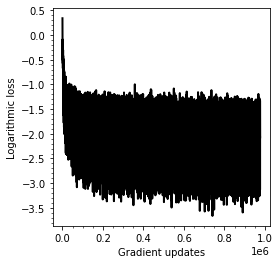

In [17]:
from tqdm import tqdm


optimizer = torch.optim.Adam(
                ratio_estimator.parameters(),
                amsgrad=True,
                lr=0.001,
                weight_decay=0
)

losses = []
for epoch in tqdm(range(epochs)):
    data_loader = torch.utils.data.DataLoader(dataset, num_workers=2, batch_size=batch_size, drop_last=True)
    num_batches = len(data_loader)
    data_loader = iter(data_loader)
    for batch_index in range(num_batches):
        optimizer.zero_grad()
        inputs, outputs = next(data_loader)
        inputs = inputs.to(hypothesis.accelerator)
        outputs = outputs.to(hypothesis.accelerator)
        loss = criterion(inputs=inputs, outputs=outputs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f'Epoch done : {epoch+1} / {epochs}')
    
losses = np.array(losses)
plt.plot(np.log(losses), lw=2, color="black")
plt.minorticks_on()
plt.xlabel("Gradient updates")
plt.ylabel("Logarithmic loss")
make_square(plt.gca())
plt.show()

In [18]:
torch.save(ratio_estimator.state_dict(), '../outputs/ratio_estimator_tractable_1016')

In [7]:
ratio_estimator = ratio_estimator.cpu()
ratio_estimator.eval()

LikelihoodToEvidenceRatioEstimatorMLP(
  (mlp): MultiLayeredPerceptron(
    (mapping): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Sequential(
        (0): ELU(alpha=1.0)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): Sequential(
        (0): ELU(alpha=1.0)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [8]:
torch.save(ratio_estimator.state_dict(), '../outputs/ratio_estimator_simple_demo')

## Posterior inference

In [19]:
theta_star = torch.Tensor([0.7, -2.9, -1.0, -0.9, 0.6]).view(1, -1)
observation = torch.Tensor(np.load('observations.npy'))

## Markov chain Monte Carlo

In [20]:
theta_star, observation # (tensor(4.6293), tensor([[4.3165]]))

(tensor([[ 0.7000, -2.9000, -1.0000, -0.9000,  0.6000]]),
 tensor([[ 0.7565, -2.4123, -0.3019, -3.5528,  1.4937, -3.2792,  1.8211, -3.9903]]))

In [21]:
from hypothesis.inference.transition_distribution import MultivariateNormal

transition = MultivariateNormal(torch.eye(5))

In [27]:
ratio_estimator.eval()

LikelihoodToEvidenceRatioEstimatorMLP(
  (mlp): MultiLayeredPerceptron(
    (mapping): Sequential(
      (0): Linear(in_features=13, out_features=64, bias=True)
      (1): Sequential(
        (0): SELU()
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): Sequential(
        (0): SELU()
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (3): SELU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [28]:
from hypothesis.inference.mcmc import AALRMetropolisHastings

sampler = AALRMetropolisHastings(prior, ratio_estimator, transition)

In [31]:
from hypothesis.visualization.util import make_square

def plot_trace(chain, theta_index=1):
    nrows = 1
    figure, rows = plt.subplots(nrows, 2, sharey=False, sharex=False, figsize=(2 * 7, 2))
    num_samples = chain.size
    def display(ax_trace, ax_density):
        # Trace
        ax_trace.minorticks_on()
        ax_trace.plot(range(num_samples), chain, color="black", lw=2)
        ax_trace.set_xlim([0, num_samples])
        ax_trace.set_xticks([])
        ax_trace.set_ylabel(r"$\theta_" + str(theta_index) + "$")
        limits = ax_trace.get_ylim()
        # Density
        ax_density.minorticks_on()
        ax_density.hist(chain, bins=50, lw=2, color="black", histtype="step", density=True)
        ax_density.yaxis.tick_right()
        ax_density.yaxis.set_label_position("right")
        ax_density.set_ylabel("Probability mass function")
        ax_density.set_xlabel(r"$\theta_" + str(theta_index) + "$")
        ax_density.set_xlim(limits)
        # Aspects
        make_square(ax_density)
        ax_trace.set_aspect("auto")
        ax_trace.set_position([0, 0, .7, 1])
        ax_density.set_position([.28, 0, 1, 1])
    if nrows > 1:
        for index, (ax_trace, ax_density) in enumerate(rows):
            display(ax_trace, ax_density, theta_index=index)
    else:
        ax_trace, ax_density = rows
        display(ax_trace, ax_density)

    return figure

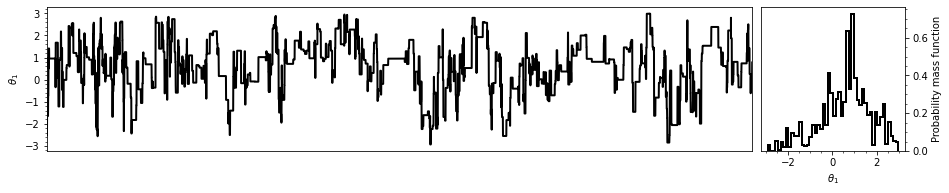

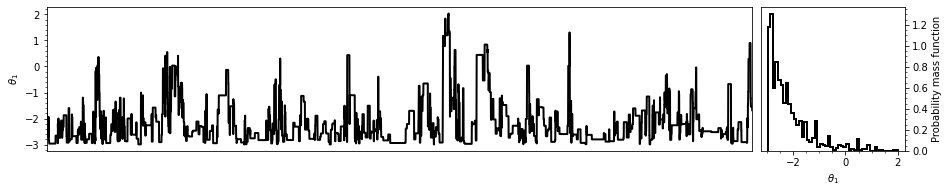

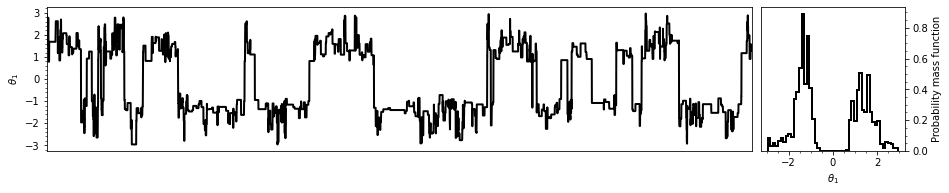

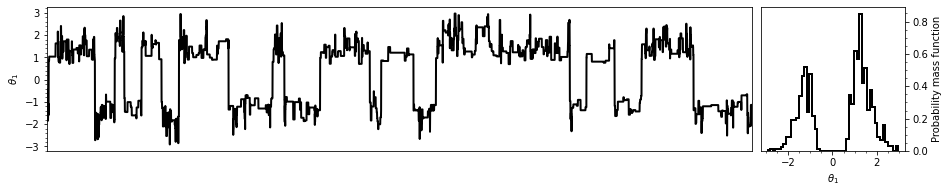

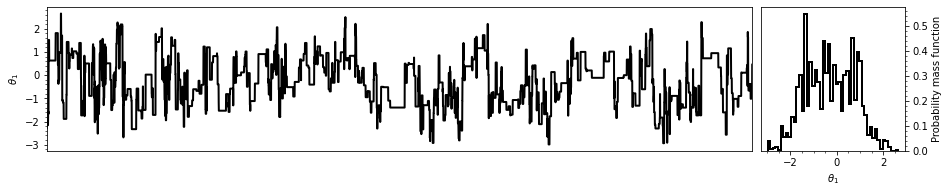

In [33]:


theta = prior.sample()
burnin_chain = sampler.sample(observation, theta, num_samples=20000)



for ind, burnin_chain_individual in enumerate(np.transpose(burnin_chain.samples.numpy())):
    figure = plot_trace(burnin_chain_individual)
    plt.show()

In [35]:
import time

theta = burnin_chain[-1]
print(theta)

start = time.monotonic()
chain = sampler.sample(observation, theta, num_samples=1000000)
end = time.monotonic()

print('Time in seconds : ', end-start)

tensor([ 0.7943, -1.6957,  1.2793, -2.0731,  0.4680])
Time in seconds :  737.185192762001


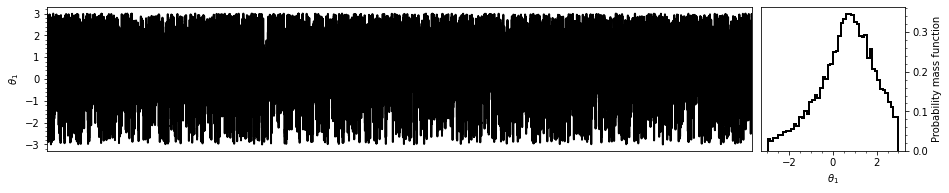

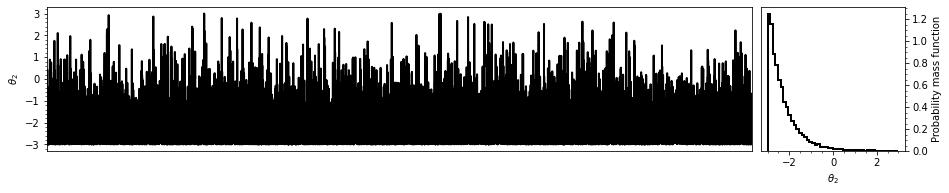

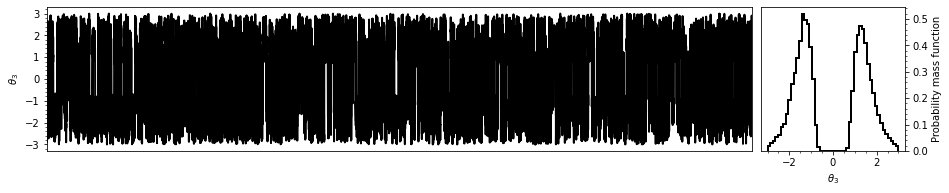

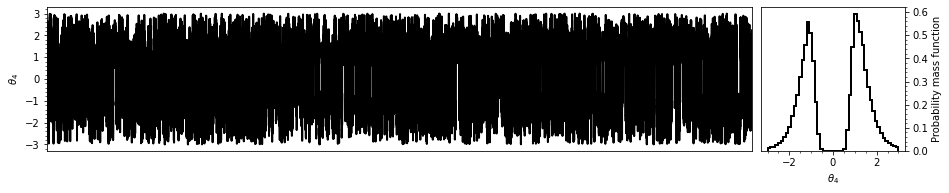

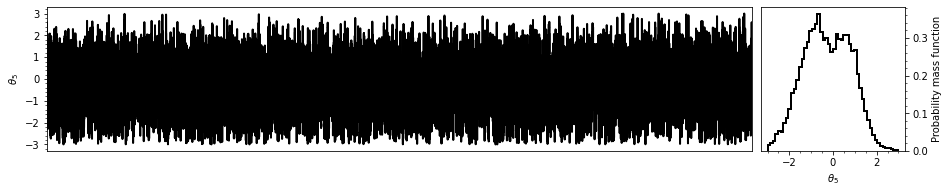

In [36]:
for ind, chain_individual in enumerate(np.transpose(chain.samples.numpy())):
    figure = plot_trace(chain_individual, theta_index=ind+1)
    plt.show()

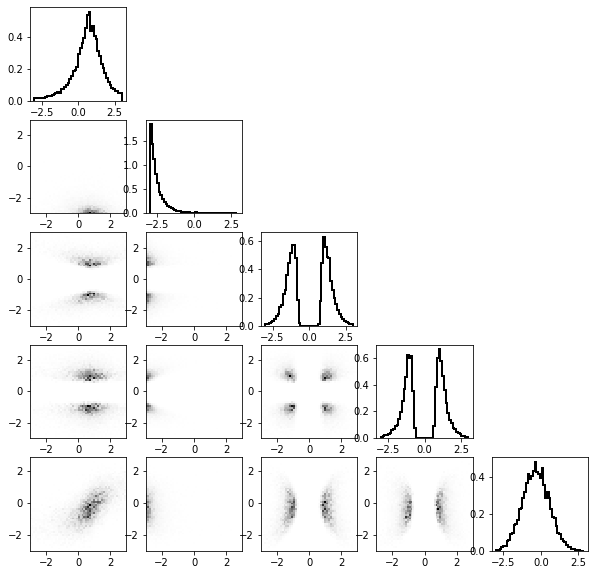

In [46]:
fig, axes = plt.subplots(figsize=(10, 10), ncols=5, nrows=5)
x = np.linspace(0, 10, 100)
for i in range(5):
    for j in range(5):
        if i<j:
            axes[i, j].axis('off')
        elif i==j:
            axes[i, j].hist(mcmc_samples_gt[:,i], bins=50, lw=2, color="black", histtype="step", density=True)
        else:
            axes[i, j].hist2d(mcmc_samples_gt[:,j], mcmc_samples_gt[:,i], bins=50, cmap='Greys')

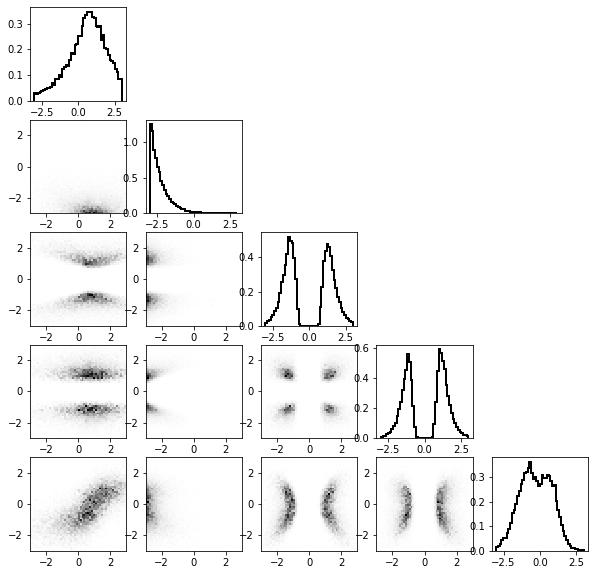

In [45]:
fig, axes = plt.subplots(figsize=(10, 10), ncols=5, nrows=5)
x = np.linspace(0, 10, 100)
for i in range(5):
    for j in range(5):
        if i<j:
            axes[i, j].axis('off')
        elif i==j:
            axes[i, j].hist(chain.samples.numpy()[:,i], bins=50, lw=2, color="black", histtype="step", density=True)
        else:
            axes[i, j].hist2d(chain.samples.numpy()[:,j], chain.samples.numpy()[:,i], bins=50, cmap='Greys')